In [1]:
###########
# 載入套件 #
###########
import findspark
findspark.init()
import pyspark
findspark.find()
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *


In [4]:
############################
# 建立Spark相關語法&讀取資料 #
############################
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", 'true')
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(spark)
data_jan = spark.read.csv('./yellow_tripdata_2009-01.csv', header=True, sep=',')
data_feb = spark.read.csv('./yellow_tripdata_2009-02.csv', header=True, sep=',')
data_mar = spark.read.csv('./yellow_tripdata_2009-03.csv', header=True, sep=',')



In [5]:
###########
# 資料清理 #
###########
concat_data = data_jan.union(data_feb)
concat_data = concat_data.union(data_mar)
concat_data = concat_data.filter(concat_data.Start_Lon != 0)
concat_data = concat_data.filter(concat_data.Start_Lat != 0)
concat_data = concat_data.filter(concat_data.End_Lon != 0)
concat_data = concat_data.filter(concat_data.End_Lat != 0)
concat_data = concat_data.filter(concat_data.Fare_Amt > 1)
concat_data = concat_data.filter(concat_data.Passenger_Count > 0)
concat_data = concat_data.withColumn('Payment_Type_New', when(concat_data.Payment_Type == 'CASH', 'Cash').when(concat_data.Payment_Type == 'CREDIT', 'Credit').otherwise(concat_data.Payment_Type))



In [6]:
######
# Q1 #
######
#Q1-1
concat_data.groupby('Start_Lon','Start_Lat').count().sort('count', ascending=False).show(truncate=False,n=10)



+-------------------+------------------+-----+
|Start_Lon          |Start_Lat         |count|
+-------------------+------------------+-----+
|-73.137393000000003|41.366137999999999|54541|
|-73.951818000000003|40.733696999999999|5197 |
|-73.988536999999994|40.698458000000002|2286 |
|-73.989039000000005|40.75808          |1336 |
|-73.945795000000004|40.778751999999997|1331 |
|-73.989053999999996|40.758087000000003|1136 |
|-73.937512999999996|40.758152000000003|1042 |
|-73.952003000000005|40.733759999999997|859  |
|-73.991084999999998|40.733310000000003|827  |
|-73.989047999999997|40.758083999999997|774  |
+-------------------+------------------+-----+
only showing top 10 rows



In [5]:
#Q1-2
concat_data.groupby('End_Lon','End_Lat').count().sort('count', ascending=False).show(truncate=False,n=10)



+-------------------+------------------+-----+
|End_Lon            |End_Lat           |count|
+-------------------+------------------+-----+
|-73.137393000000003|41.366137999999999|45724|
|-73.951818000000003|40.733696999999999|5197 |
|-73.988536999999994|40.698458000000002|2286 |
|-73.989039000000005|40.75808          |1336 |
|-73.945795000000004|40.778751999999997|1331 |
|-73.989053999999996|40.758087000000003|1136 |
|-73.937512999999996|40.758152000000003|1044 |
|-73.952003000000005|40.733759999999997|859  |
|-73.991084999999998|40.733310000000003|828  |
|-73.989047999999997|40.758083999999997|774  |
+-------------------+------------------+-----+
only showing top 10 rows



In [6]:
######
# Q2 #
######
concat_data = concat_data.withColumn("pickup", hour('Trip_Pickup_DateTime'))
concat_data.groupby('pickup').count().sort('count', ascending=False).show(truncate=False, n=24)



+------+-------+
|pickup|count  |
+------+-------+
|19    |2730956|
|18    |2647195|
|20    |2459694|
|21    |2338148|
|22    |2267936|
|17    |2218048|
|15    |2053659|
|14    |2027168|
|23    |1976869|
|12    |1942527|
|13    |1934311|
|8     |1912203|
|9     |1907802|
|16    |1899858|
|11    |1779785|
|10    |1740495|
|0     |1596750|
|7     |1453983|
|1     |1172730|
|2     |880165 |
|6     |791182 |
|3     |664392 |
|4     |480862 |
|5     |373397 |
+------+-------+



<AxesSubplot:xlabel='Payment_Type_New'>

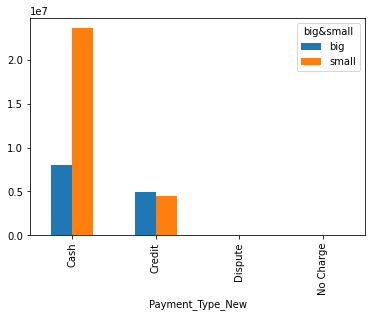

In [9]:
######
# Q3 #
######
import matplotlib.pyplot as plt
from pyspark.sql.functions import mean as _mean, col
stats_data = concat_data.select(_mean(col('Total_Amt')).alias('mean')).collect()
data_mean = stats_data[0]['mean']
new_concat_data = concat_data.withColumn('big&small', when(concat_data.Total_Amt >= data_mean, 'big').when(concat_data.Total_Amt < data_mean, 'small'))

bar_plot = new_concat_data.groupby('Payment_Type_New','big&small').count().sort('count', ascending=False).toPandas()
bar_plot.pivot('Payment_Type_New','big&small','count').plot.bar(stacked=False)

